In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import openai

In [ ]:
# Load the OpenAI API key
with open("OPENAIKEY.txt", "r") as file:
    api_key = file.read().strip()

openai.api_key = api_key

In [ ]:
# Load the ferry trips data
ferry_data = pd.read_csv('ferry_trips_data.csv')

# Display the first few rows to understand the structure
ferry_data.head()

# %%
# Summary of the dataset
ferry_data.info()

# Summary statistics
ferry_data.describe()

In [ ]:
# Load route descriptions
with open("route_descriptions.md", "r") as file:
    route_descriptions = file.read()

# Load ferries information
with open("ferries.json", "r") as f:
    ferries = json.load(f)

# Define routes and optimization plans
routes = {
    "Aspöleden": {
        "schedule": "schedules/aspoleden_utg11_2020_w.csv",
        "fleet": ferries.get("Yxlan"),
        "optimizations": """
Retain only Yxlan during late-night hours (10 PM–6 AM).
Schedule trips every 50 minutes instead of 25 minutes during off-peak times.
Use both ferries during peak hours to meet demand.
"""
    },
    "Oxdjupsleden": {
        "schedule": "schedules/Vaxholms-Oxdjupsleden_utg16_1_WEB_20230401.csv",
        "fleet": ferries.get("Fragancia"),
        "optimizations": """
Reduce trip frequency to every 15 minutes during late-night hours (10 PM–6 AM).
Retain Fragancia for all operations to minimize emissions.
"""
    },
    "Furusundsleden": {
        "schedule": "schedules/furusundsleden-blidoleden_utg9_200623_w.csv",
        "fleet": ferries.get("Merkurius"),
        "optimizations": """
Operate only Merkurius during winter weekdays.
Retain both Merkurius and Gulli during summer holidays and weekends.
Use Gulli for off-peak trips to reduce emissions.
"""
    },
    "Vaxholmsleden": {
        "schedule": "schedules/Vaxholms-Oxdjupsleden_utg16_1_WEB_20230401.csv",
        "fleet": ferries.get("Nina"),
        "optimizations": """
Retain only Castella during late-night hours (10 PM–6 AM).
Schedule trips every 20 minutes during late-night periods.
Use Nina and Castella during peak times to meet demand.
"""
    },
    "Ljusteröleden": {
        "schedule": "schedules/ljusteroleden_oktober_april_utg22_2020_w.csv",
        "fleet": ferries.get("Jupiter"),
        "optimizations": """
Retain both ferries during summer weekends and holidays for peak demand.
Use only Jupiter during winter weekdays to reduce emissions.
Switch to Frida during off-peak times to minimize fuel usage.
"""
    }
}


Processing route: Aspöleden


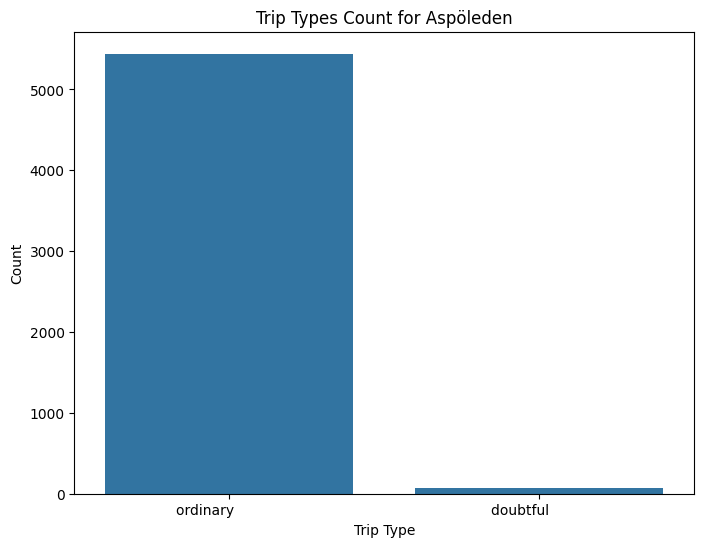

Total vehicles left at terminal for Aspöleden: 1207
Average vehicles left at terminal per trip:
vehicles_left_at_terminal_outbound    0.072543
vehicles_left_at_terminal_inbound     0.146355
dtype: float64


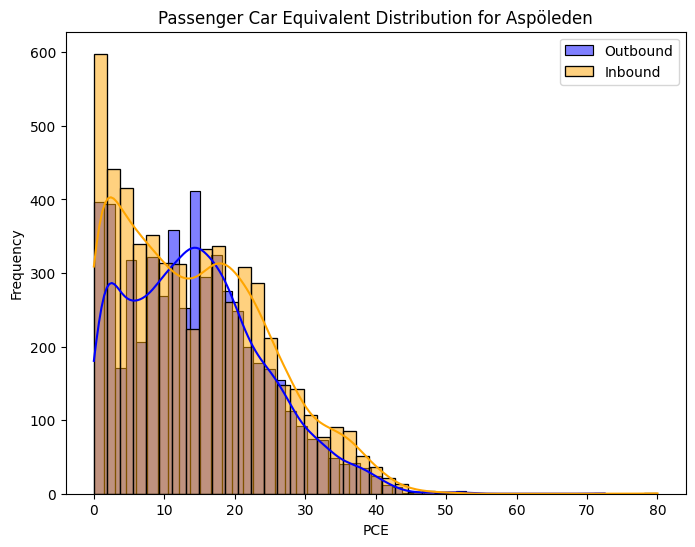

Optimized schedule saved for Aspöleden at optimized_schedules/Aspöleden_optimized_schedule.csv.
Processing route: Oxdjupsleden


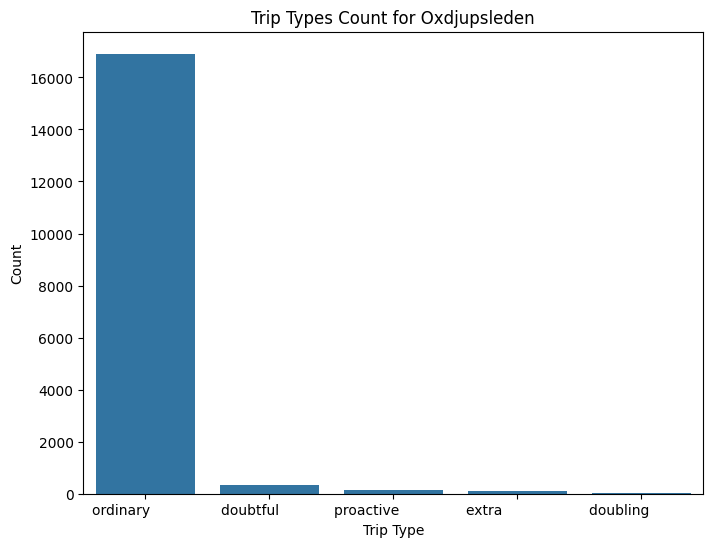

Total vehicles left at terminal for Oxdjupsleden: 605
Average vehicles left at terminal per trip:
vehicles_left_at_terminal_outbound    0.013596
vehicles_left_at_terminal_inbound     0.020965
dtype: float64


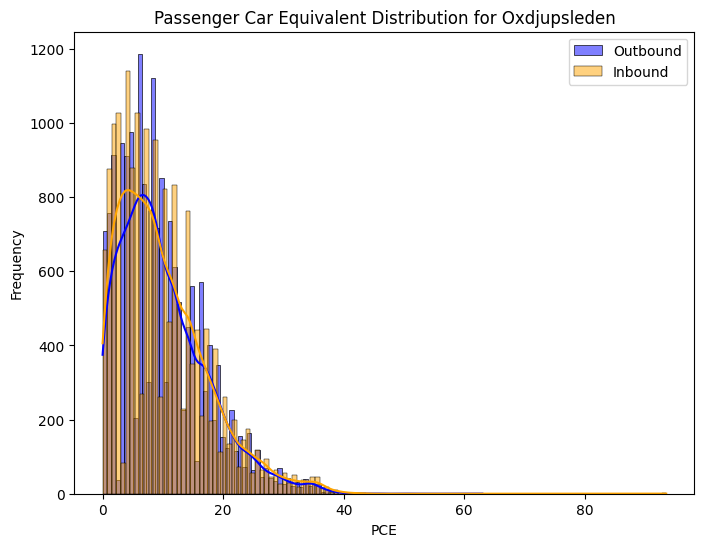

Optimized schedule saved for Oxdjupsleden at optimized_schedules/Oxdjupsleden_optimized_schedule.csv.
Processing route: Furusundsleden


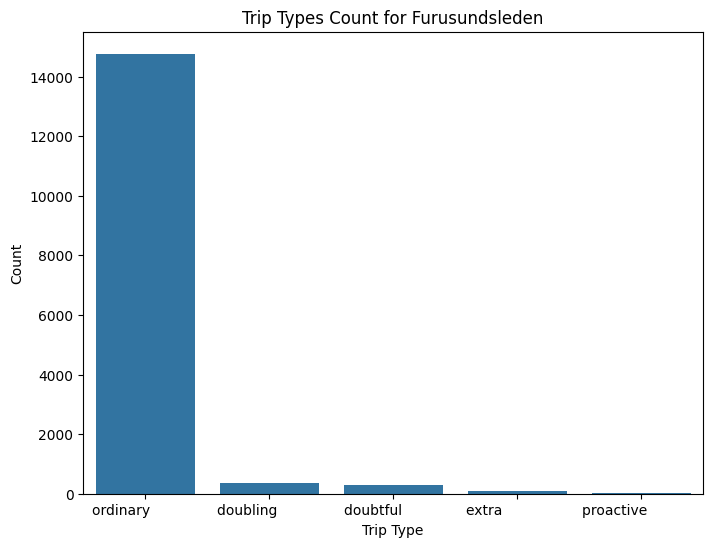

Total vehicles left at terminal for Furusundsleden: 18125
Average vehicles left at terminal per trip:
vehicles_left_at_terminal_outbound    0.584931
vehicles_left_at_terminal_inbound     0.581264
dtype: float64


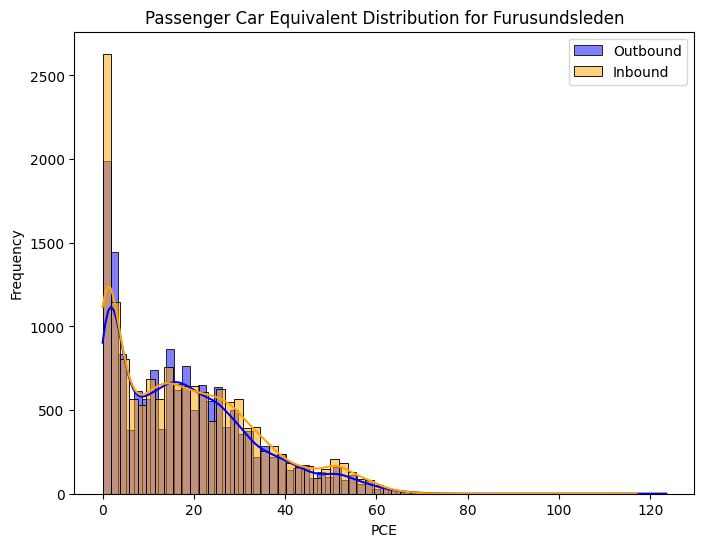

Optimized schedule saved for Furusundsleden at optimized_schedules/Furusundsleden_optimized_schedule.csv.
Processing route: Vaxholmsleden


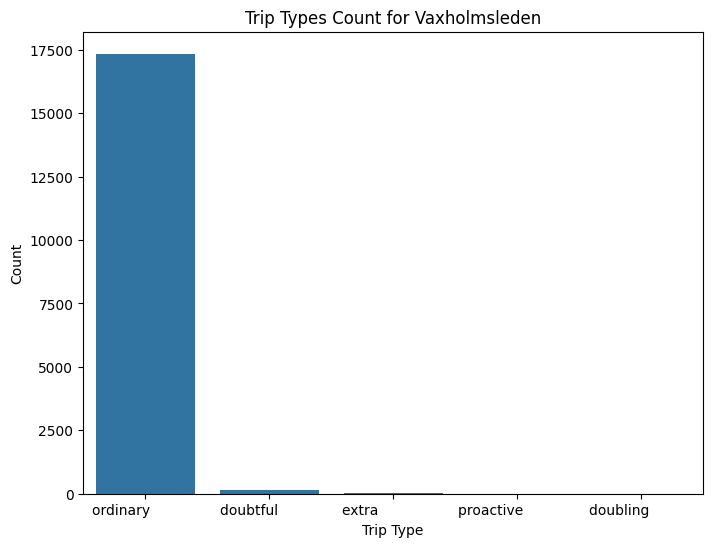

Total vehicles left at terminal for Vaxholmsleden: 5327
Average vehicles left at terminal per trip:
vehicles_left_at_terminal_outbound    0.143689
vehicles_left_at_terminal_inbound     0.160416
dtype: float64


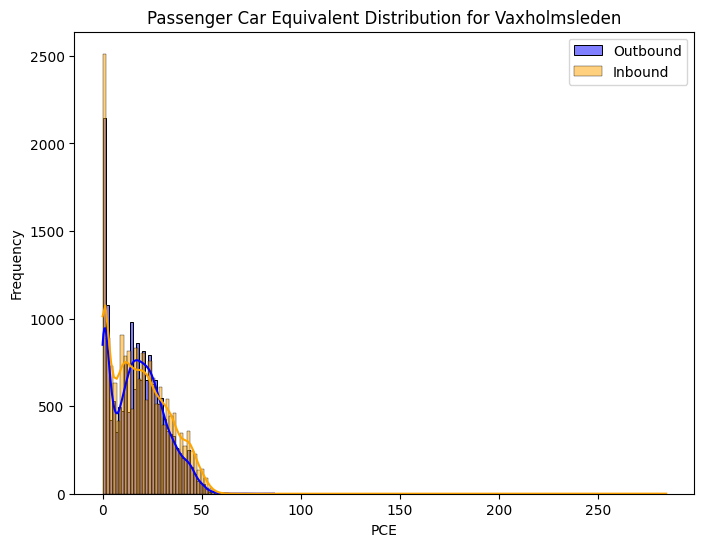

Optimized schedule saved for Vaxholmsleden at optimized_schedules/Vaxholmsleden_optimized_schedule.csv.
Processing route: Ljusteröleden


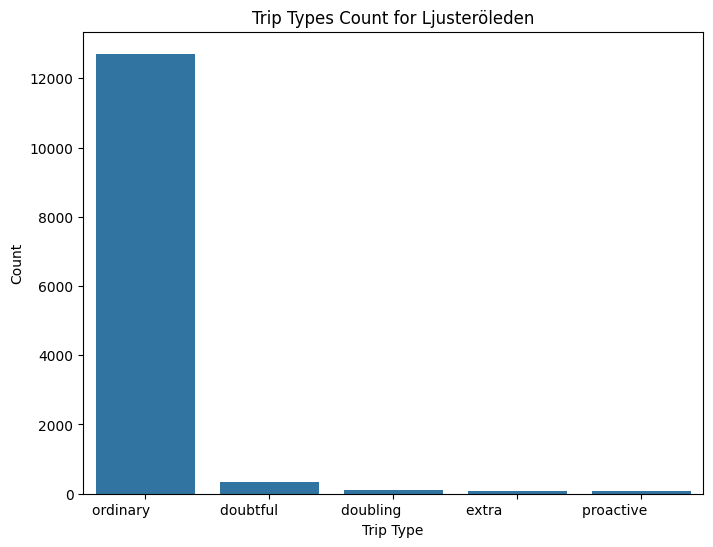

Total vehicles left at terminal for Ljusteröleden: 19484
Average vehicles left at terminal per trip:
vehicles_left_at_terminal_outbound    0.739608
vehicles_left_at_terminal_inbound     0.727560
dtype: float64


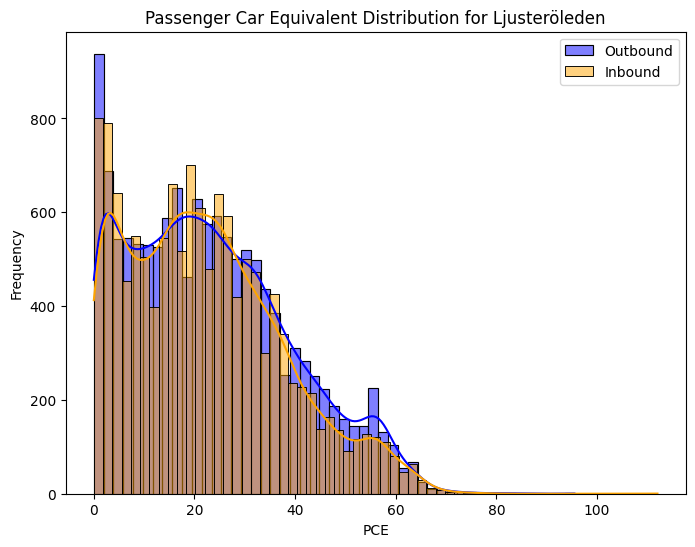

Optimized schedule saved for Ljusteröleden at optimized_schedules/Ljusteröleden_optimized_schedule.csv.


In [8]:
# Prepare a directory for optimized schedules
os.makedirs("optimized_schedules", exist_ok=True)

client = openai.OpenAI(api_key=api_key)

# Function to query OpenAI for optimization suggestions
def query_openai(prompt, model="gpt-4", max_tokens=3000):
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are an expert in transportation and ferry schedule optimization."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=0.5
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error querying OpenAI: {e}")
        return None

# Function to generate the optimization prompt
def generate_prompt(route, route_desc, schedule_file, fleet, optimizations):
    try:
        schedule_df = pd.read_csv(schedule_file)
        schedule_content = schedule_df.head(10).to_csv(index=False)  # Include the top 10 rows for context
    except Exception as e:
        schedule_content = f"Error reading schedule file: {e}"

    # Extract route-specific description
    route_desc_lines = route_desc.split('\n')
    route_specific_desc = ""
    capture = False
    for line in route_desc_lines:
        if line.strip() == f"## {route}":
            capture = True
            continue
        if line.strip().startswith("## ") and capture:
            break
        if capture:
            route_specific_desc += line + "\n"

    return f"""
You are tasked with optimizing ferry schedules and fleet usage for the route '{route}'.

Route Details:
{route_specific_desc}

Current Schedule (CSV format snippet):
{schedule_content}

Current Fleet:
{json.dumps(fleet, indent=2)}

Optimization Goals:
{optimizations}

Provide:
1. A detailed optimized schedule in CSV format. DO NOT SIMPLIFY IT.
2. Adjusted fleet assignments for peak and off-peak hours.
3. Feasibility analysis for proposed changes, especially ensuring demand is met and emissions are reduced.
4. Simulated amount of emissions decreased and demand being met.
"""

# Function to save optimized schedules
def save_optimized_schedule(route, schedule_data):
    try:
        output_file = f"optimized_schedules/{route}_optimized_schedule.csv"
        with open(output_file, "w") as file:
            file.write(schedule_data)
        print(f"Optimized schedule saved for {route} at {output_file}.")
    except Exception as e:
        print(f"Error saving optimized schedule for {route}: {e}")

# Perform Analysis and Optimization for Each Route
for route, details in routes.items():
    print(f"Processing route: {route}")
    # Load schedule data
    schedule_file = details["schedule"]
    fleet = details["fleet"]
    optimizations = details["optimizations"]
    
    # Load route-specific ferry data
    route_ferry_data = ferry_data[ferry_data['route_name'] == route]
    
    # Perform data analysis similar to the sample notebook
    # Analyze Trip Types
    trip_type_counts = route_ferry_data['trip_type'].value_counts()
    plt.figure(figsize=(8,6))
    sns.barplot(x=trip_type_counts.index, y=trip_type_counts.values)
    plt.title(f'Trip Types Count for {route}')
    plt.xlabel('Trip Type')
    plt.ylabel('Count')
    plt.show()
    
    # Analyze Vehicles Left at Terminal
    vehicles_left_total = route_ferry_data['vehicles_left_at_terminal_outbound'].sum() + route_ferry_data['vehicles_left_at_terminal_inbound'].sum()
    vehicles_left_avg = route_ferry_data[['vehicles_left_at_terminal_outbound', 'vehicles_left_at_terminal_inbound']].mean()
    print(f"Total vehicles left at terminal for {route}: {vehicles_left_total}")
    print("Average vehicles left at terminal per trip:")
    print(vehicles_left_avg)
    
    # Analyze PCE (Passenger Car Equivalent)
    pce_outbound = route_ferry_data['passenger_car_equivalent_outbound']
    pce_inbound = route_ferry_data['passenger_car_equivalent_inbound']
    
    plt.figure(figsize=(8,6))
    sns.histplot(pce_outbound, color='blue', label='Outbound', kde=True)
    sns.histplot(pce_inbound, color='orange', label='Inbound', kde=True)
    plt.title(f'Passenger Car Equivalent Distribution for {route}')
    plt.xlabel('PCE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # Generate the prompt for OpenAI
    prompt = generate_prompt(route, route_descriptions, schedule_file, fleet, optimizations)
    
    # Query OpenAI for optimization suggestions
    result = query_openai(prompt)
    if result:
        save_optimized_schedule(route, result)
    else:
        print(f"No optimization result for {route}.")


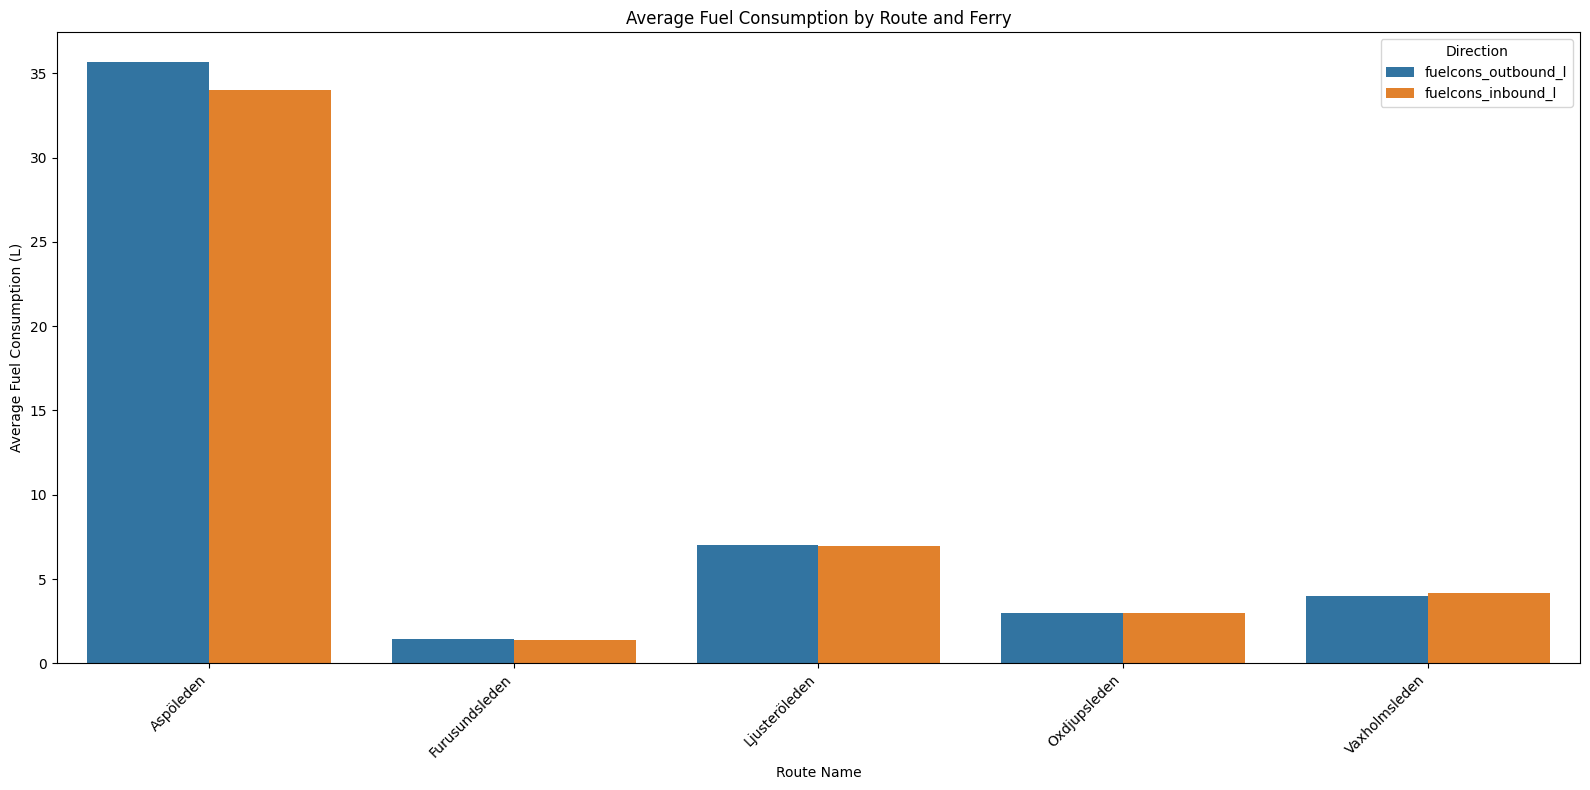

In [9]:
def fuel_consumption_analysis(df):
    consumption_data = df[['route_name', 'ferry_name', 'fuelcons_outbound_l', 'fuelcons_inbound_l']]
    # Drop null values
    consumption_data = consumption_data.dropna()
    # Aggregating mean fuel consumption by route_name and ferry_name
    fuel_consumption_by_route_ferry = consumption_data.groupby(['route_name', 'ferry_name']).mean().reset_index()
    fuel_consumption_by_route_ferry_melted = fuel_consumption_by_route_ferry.melt(
        id_vars=['route_name', 'ferry_name'],
        value_vars=['fuelcons_outbound_l', 'fuelcons_inbound_l'],
        var_name='direction',
        value_name='average_fuel_consumption_l'
    )
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=fuel_consumption_by_route_ferry_melted,
        x='route_name',
        y='average_fuel_consumption_l',
        hue='direction'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Fuel Consumption by Route and Ferry')
    plt.xlabel('Route Name')
    plt.ylabel('Average Fuel Consumption (L)')
    plt.legend(title='Direction')
    plt.tight_layout()
    plt.show()

fuel_consumption_analysis(ferry_data)

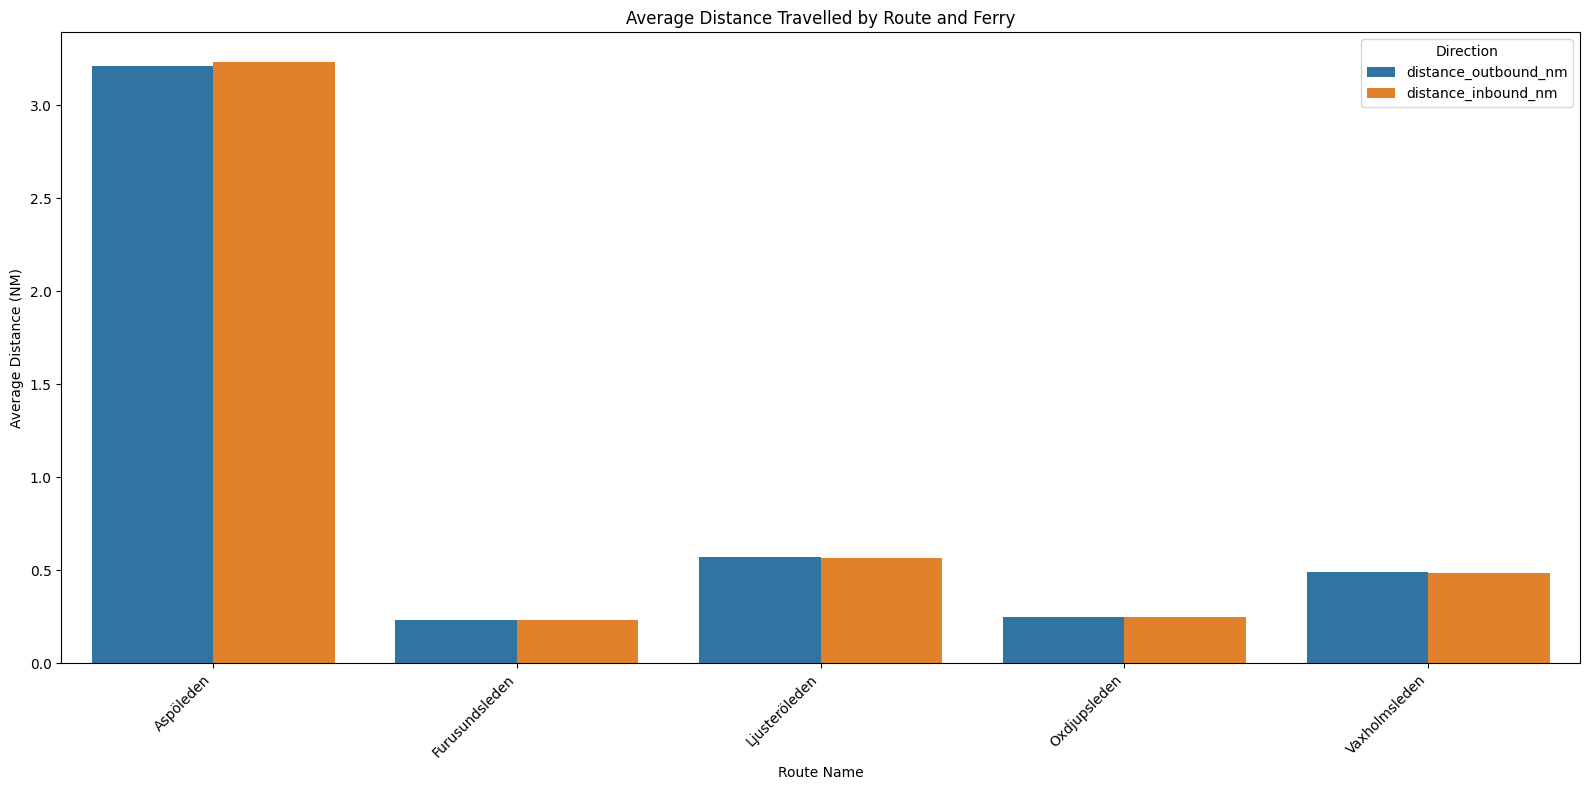

In [10]:
def distance_travelled_analysis(df):
    distance_data = df[['route_name', 'ferry_name', 'distance_outbound_nm', 'distance_inbound_nm']]
    # Drop null values
    distance_data = distance_data.dropna()
    # Aggregating mean distance by route_name and ferry_name
    distance_by_route_ferry = distance_data.groupby(['route_name', 'ferry_name']).mean().reset_index()
    distance_by_route_ferry_melted = distance_by_route_ferry.melt(
        id_vars=['route_name', 'ferry_name'],
        value_vars=['distance_outbound_nm', 'distance_inbound_nm'],
        var_name='direction',
        value_name='average_distance_nm'
    )
    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=distance_by_route_ferry_melted,
        x='route_name',
        y='average_distance_nm',
        hue='direction'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Distance Travelled by Route and Ferry')
    plt.xlabel('Route Name')
    plt.ylabel('Average Distance (NM)')
    plt.legend(title='Direction')
    plt.tight_layout()
    plt.show()

distance_travelled_analysis(ferry_data)


In [11]:
def efficiency_improvements(df):
    # Convert 'time_departure' to datetime and extract date and hour
    df['time_departure'] = pd.to_datetime(df['time_departure'], errors='coerce')
    df = df.dropna(subset=['time_departure'])
    df['hour'] = df['time_departure'].dt.hour
    df['date'] = df['time_departure'].dt.date

    # Fill NaN values in fuel consumption columns
    df['fuelcons_outbound_l'] = df['fuelcons_outbound_l'].fillna(0)
    df['fuelcons_inbound_l'] = df['fuelcons_inbound_l'].fillna(0)

    # Aggregate data
    conditions = df.groupby(['route_name', 'ferry_name', 'hour']).agg({
        'passenger_car_equivalent_outbound': 'sum',
        'passenger_car_equivalent_inbound': 'sum',
        'fuelcons_outbound_l': ['mean', 'sum', 'std'],
        'fuelcons_inbound_l': ['mean', 'sum', 'std'],
        'distance_outbound_nm': ['mean', 'sum'],
        'distance_inbound_nm': ['mean', 'sum']
    }).reset_index()

    # Flatten column names correctly
    conditions.columns = [
        col if not isinstance(col, tuple) or col[1] == '' else f"{col[0]}_{col[1]}"
        for col in conditions.columns.values
    ]

    # Calculate total passenger car equivalents
    conditions['total_passenger_car_equivalent'] = (
        conditions['passenger_car_equivalent_outbound_sum'] +
        conditions['passenger_car_equivalent_inbound_sum']
    )

    # Determine thresholds
    high_threshold = conditions['total_passenger_car_equivalent'].quantile(0.95)
    low_threshold = conditions['total_passenger_car_equivalent'].mean()

    # Annotate demand conditions
    conditions['demand_level'] = 'normal'
    conditions.loc[conditions['total_passenger_car_equivalent'] > high_threshold, 'demand_level'] = 'high'
    conditions.loc[conditions['total_passenger_car_equivalent'] < low_threshold, 'demand_level'] = 'low'

    # Calculate fuel efficiency
    conditions['fuel_efficiency_outbound'] = (
        conditions['distance_outbound_nm_sum'] /
        conditions['fuelcons_outbound_l_sum'].replace(0, float('nan'))
    )
    conditions['fuel_efficiency_inbound'] = (
        conditions['distance_inbound_nm_sum'] /
        conditions['fuelcons_inbound_l_sum'].replace(0, float('nan'))
    )

    # Handle NaN results due to division by zero for fuel efficiency
    conditions = conditions.fillna(0)

    return conditions

In [13]:
# Plot demand levels over hours
plt.figure(figsize=(12,6))
sns.lineplot(data=conditions, x='hour_', y='total_passenger_car_equivalent', hue='demand_level')
plt.title('Demand Levels Over Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Passenger Car Equivalent (PCE)')
plt.legend(title='Demand Level')
plt.show()

ValueError: Could not interpret value `hour_` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [ ]:
def analyze_and_optimize_schedule(schedule_df, demand_conditions, boat_info_df):
    max_capacity = boat_info_df['capacity_passenger_car_equivalent'].iloc[0]
    high_demand = demand_conditions[demand_conditions['demand_level'] == 'high']
    low_demand = demand_conditions[demand_conditions['demand_level'] == 'low']
    # Group by hour
    high_demand_by_hour = high_demand.groupby(['hour_']).agg({'total_passenger_car_equivalent': 'mean'}).reset_index()
    low_demand_by_hour = low_demand.groupby(['hour_']).agg({'total_passenger_car_equivalent': 'mean'}).reset_index()
    # Plot aggregated demand by hour
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=demand_conditions, x='hour_', y='total_passenger_car_equivalent', hue='demand_level')
    plt.axhline(max_capacity, color='red', linestyle='--', label='Max Capacity')
    plt.title('Demand by Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Total Passenger Car Equivalent (PCE)')
    plt.legend(title='Demand Level')
    plt.show()
    # Recommendations
    print("\nSchedule Optimization Recommendations:")
    # High-demand recommendations
    for _, row in high_demand_by_hour.iterrows():
        extra_needed = row['total_passenger_car_equivalent'] - max_capacity
        if extra_needed > 0:
            print(f"High-demand: Around {int(row['hour_'])}:00, consider additional capacity for approximately {extra_needed:.1f} PCEs.")
    # Low-demand recommendations
    for _, row in low_demand_by_hour.iterrows():
        print(f"Low-demand: Around {int(row['hour_'])}:00, consider consolidating trips - only approximately {row['total_passenger_car_equivalent']:.1f} PCEs.")
    optimal_schedule = schedule_df.copy()
    return optimal_schedule

# Analyze and optimize schedule for each route
for route, details in routes.items():
    print(f"\nAnalyzing and optimizing schedule for {route}")
    schedule_file = details["schedule"]
    fleet = details["fleet"]
    boat_info_df = pd.DataFrame([fleet])
    schedule_df = pd.read_csv(schedule_file)
    route_ferry_data = ferry_data[ferry_data['route_name'] == route]
    demand_conditions = efficiency_improvements(route_ferry_data)
    optimal_schedule = analyze_and_optimize_schedule(schedule_df, demand_conditions, boat_info_df)
    # Save the optimized schedule
    output_file = f"optimized_schedules/{route}_optimized_schedule.csv"
    optimal_schedule.to_csv(output_file, index=False)
    print(f"Optimized schedule saved for {route} at {output_file}.")


In [ ]:
def optimize_schedule(schedule_df, high_demand_hours, low_demand_hours):
    # Convert 'Timestamp' or relevant time column to datetime
    schedule_df['Timestamp'] = pd.to_datetime(schedule_df['Timestamp'], errors='coerce')
    # Drop rows with invalid timestamps
    schedule_df = schedule_df.dropna(subset=['Timestamp'])
    # Extract the hour from the valid timestamps
    schedule_df['Hour'] = schedule_df['Timestamp'].dt.hour
    # Remove trips during low-demand hours
    optimized_schedule = schedule_df[~schedule_df['Hour'].isin(low_demand_hours)]
    # Optionally add more trips for high-demand hours
    high_demand_trips = optimized_schedule[optimized_schedule['Hour'].isin(high_demand_hours)]
    high_demand_trips = pd.concat([high_demand_trips, high_demand_trips])  # Simplistic doubling
    # Combine and sort
    optimized_schedule = pd.concat([optimized_schedule, high_demand_trips])
    optimized_schedule = optimized_schedule.sort_values('Timestamp').reset_index(drop=True)
    return optimized_schedule

# Optimize schedules for each route based on demand insights
for route, details in routes.items():
    print(f"\nOptimizing schedule for {route} based on demand")
    schedule_file = details["schedule"]
    schedule_df = pd.read_csv(schedule_file)
    route_ferry_data = ferry_data[ferry_data['route_name'] == route]
    demand_conditions = efficiency_improvements(route_ferry_data)
    high_demand_hours = demand_conditions[demand_conditions['demand_level'] == 'high']['hour_'].unique().tolist()
    low_demand_hours = demand_conditions[demand_conditions['demand_level'] == 'low']['hour_'].unique().tolist()
    optimized_schedule_df = optimize_schedule(schedule_df, high_demand_hours, low_demand_hours)
    # Save the optimized schedule
    output_file = f"optimized_schedules/{route}_optimized_schedule.csv"
    optimized_schedule_df.to_csv(output_file, index=False)
    print(f"Optimi